### Get the ClimDiv data

In [1]:
import pandas as pd
import csv
import os
import polars as pl # For reading the CSV efficiently

In [2]:
# -----------------------------------------------------------------
# 1) Read the county-to-climdivs mapping file into a lookup dict
#    The file has 3 columns (POSTAL_FIPS_ID, NCDC_FIPS_ID, CLIMDIV_ID)
#    We'll map NCDC_FIPS_ID -> (POSTAL_FIPS_ID, CLIMDIV_ID)
# -----------------------------------------------------------------

path_raw = "corn_belt_2024_thesis/raw_data/"

mapping = {}
with open(os.path.join(path_raw, "county-to-climdivs.txt"), "r") as f:
    next(f)  # skip header line if it exists
    for line in f:
        parts = line.strip().split()
        if len(parts) != 3:
            continue
        postal_fips, ncdc_fips, climdiv_id = parts
        mapping[ncdc_fips] = (postal_fips, climdiv_id)

# -----------------------------------------------------------------
#2) Define a helper function to parse each line in tmaxcy/pcpncy
# -----------------------------------------------------------------
def parse_clim_line(line):
    """
    Given a line (string) from tmaxcy or pcpncy,
    returns a dict with raw_code, state, county, division, year, and the 12 monthly values.
    If the line can't be mapped (NCDC FIPS not found), return None.
    """
    parts = line.strip().split()
    if len(parts) < 13:
        return None  # not enough data
    
    # The first item is the 11-digit code: e.g. "01001271895"
    code = parts[0]
    monthly_values = parts[1:]  # the next 12 numbers
    
    ncdc_fips = code[:5]       #first 5 digits
    data_type = code[5:7]      #next 2 digits (27 for tmax, 01 for pcpn)
    year = code[7:]            #last 4 digits
    
    if ncdc_fips not in mapping:
        return None
    
    postal_fips, climdiv_id = mapping[ncdc_fips]
    # postal_fips e.g. "04001" => correct_state="04", correct_county="001"
    correct_state = postal_fips[:2]
    correct_county = postal_fips[2:]
    # climdiv_id e.g. "0202" => last two digits "02" for division
    division = climdiv_id[-2:]
    
    # Create a dict with the data, including the raw_code for clarity
    return {
        "raw_code": code,
        "state": correct_state,
        "county": correct_county,
        "division": division,
        "year": year,
        "Jan": monthly_values[0],
        "Feb": monthly_values[1],
        "Mar": monthly_values[2],
        "Apr": monthly_values[3],
        "May": monthly_values[4],
        "Jun": monthly_values[5],
        "Jul": monthly_values[6],
        "Aug": monthly_values[7],
        "Sep": monthly_values[8],
        "Oct": monthly_values[9],
        "Nov": monthly_values[10],
        "Dec": monthly_values[11]
    }

# -----------------------------------------------------------------
#3) Read & parse tmaxcy (temperature) lines
# -----------------------------------------------------------------
tmax_records = []
with open(os.path.join(path_raw, "240924 climdiv-tmaxcy-v1.0.0-20240906.txt"), "r") as f:
    for line in f:
        parsed = parse_clim_line(line)
        if parsed:
            tmax_records.append(parsed)

df_tmax = pd.DataFrame(tmax_records)
print("TMAX DataFrame:\n", df_tmax.head())

# -----------------------------------------------------------------
#4) Lastly Read & parse pcpncy (precipitation) lines
# -----------------------------------------------------------------
pcpn_records = []
with open(os.path.join(path_raw, "240924 climdiv-pcpncy-v1.0.0-20240906.txt"), "r") as f:
    for line in f:
        parsed = parse_clim_line(line)
        if parsed:
            pcpn_records.append(parsed)

df_pcpn = pd.DataFrame(pcpn_records)
print("PCPN DataFrame:\n", df_pcpn.head())

TMAX DataFrame:
       raw_code state county division  year    Jan    Feb    Mar    Apr    May  \
0  01001271895    01    001       03  1895  53.70  48.70  67.60  76.40  81.90   
1  01001271896    01    001       03  1896  54.20  60.80  65.30  81.60  88.50   
2  01001271897    01    001       03  1897  54.20  63.10  71.40  75.10  83.20   
3  01001271898    01    001       03  1898  60.60  59.10  71.00  72.00  89.50   
4  01001271899    01    001       03  1899  55.60  53.40  68.80  73.40  89.30   

     Jun    Jul    Aug    Sep    Oct    Nov    Dec  
0  89.20  91.10  90.40  90.90  76.00  66.60  58.00  
1  88.20  92.00  94.50  90.80  77.20  69.90  58.70  
2  95.60  93.30  89.90  88.90  81.30  68.10  58.80  
3  93.90  91.50  88.80  86.70  73.60  61.70  55.70  
4  93.70  92.20  92.60  87.50  78.40  68.10  56.60  
PCPN DataFrame:
       raw_code state county division  year   Jan   Feb    Mar   Apr   May  \
0  01001011895    01    001       03  1895  7.03  2.96   8.36  3.53  3.96   
1  0100

### Load the Daily Parquet data

In [3]:
processed_csv_filename = "df_yield_FOR_MONTHLY_COMPARE.csv"

try:
    print(f"Attempting to read CSV: {os.path.abspath(processed_csv_filename)}")
    # Read the CSV generated by the previous script,
    # explicitly setting fips_full as String (Utf8 is Polars' string type)
    df_processed_weather = pl.read_csv(
        processed_csv_filename,
        dtypes={"fips_full": pl.String}  # <--- THIS IS THE FIX
    )
    print(f"Successfully read {processed_csv_filename}")

    # Extract unique state FIPS codes
    # 'fips_full' is like "SSCCC", so state is the first 2 characters
    if "fips_full" in df_processed_weather.columns:
        unique_states_from_csv = df_processed_weather.select(
            pl.col("fips_full").str.slice(0, 2).alias("state_fips")
        ).unique().get_column("state_fips").to_list()
        print(f"\nFound {len(unique_states_from_csv)} unique states in '{processed_csv_filename}': {unique_states_from_csv}")
    else:
        print(f"Error: 'fips_full' column not found in {processed_csv_filename}. Cannot determine states.")
        unique_states_from_csv = []

except FileNotFoundError: # Should not happen now, but good to keep
    print(f"Error: Processed CSV file '{processed_csv_filename}' not found. Cannot filter.")
    unique_states_from_csv = []
except Exception as e:
    print(f"Error reading or processing '{processed_csv_filename}': {e}")
    unique_states_from_csv = []



# -----------------------------------------------------------------
# 6) Filter df_tmax and df_pcpn based on the unique states
# -----------------------------------------------------------------
if unique_states_from_csv:
    if 'df_tmax' in locals() and not df_tmax.empty:
        df_tmax['state'] = df_tmax['state'].astype(str) # Ensure comparison is str to str
        df_tmax_filtered = df_tmax[df_tmax['state'].isin(unique_states_from_csv)]
        print("\nFiltered TMAX DataFrame head:\n", df_tmax_filtered.head())
        print(f"Original TMAX rows: {len(df_tmax)}, Filtered TMAX rows: {len(df_tmax_filtered)}")
    else:
        print("\nSkipping TMAX filtering as df_tmax is not defined or is empty.")

    if 'df_pcpn' in locals() and not df_pcpn.empty:
        df_pcpn['state'] = df_pcpn['state'].astype(str) # Ensure comparison is str to str
        df_pcpn_filtered = df_pcpn[df_pcpn['state'].isin(unique_states_from_csv)]
        print("\nFiltered PCPN DataFrame head:\n", df_pcpn_filtered.head())
        print(f"Original PCPN rows: {len(df_pcpn)}, Filtered PCPN rows: {len(df_pcpn_filtered)}")
    else:
        print("\nSkipping PCPN filtering as df_pcpn is not defined or is empty.")
else:
    print("\nNo states found from CSV to filter by, or CSV not loaded. Skipping filtering of TMAX/PCPN data.")

Attempting to read CSV: c:\Users\rickg\OneDrive\Documents\GitHub\EpiNOAA-Python\df_yield_FOR_MONTHLY_COMPARE.csv


C:\Users\rickg\AppData\Local\Temp\ipykernel_25904\2461567206.py:7: DeprecationWarning: The argument `dtypes` for `read_csv` is deprecated. It has been renamed to `schema_overrides`.
  df_processed_weather = pl.read_csv(


Successfully read df_yield_FOR_MONTHLY_COMPARE.csv

Found 4 unique states in 'df_yield_FOR_MONTHLY_COMPARE.csv': ['19', '31', '27', '17']

Filtered TMAX DataFrame head:
           raw_code state county division  year    Jan    Feb    Mar    Apr  \
72800  11001271895    17    001       03  1895  29.60  29.00  50.90  66.20   
72801  11001271896    17    001       03  1896  38.20  39.30  45.80  71.90   
72802  11001271897    17    001       03  1897  31.80  38.30  48.30  60.30   
72803  11001271898    17    001       03  1898  37.00  39.50  52.50  60.90   
72804  11001271899    17    001       03  1899  34.90  27.50  41.90  63.70   

         May    Jun    Jul    Aug    Sep    Oct    Nov    Dec  
72800  75.50  85.00  85.20  86.40  81.00  62.60  48.10  38.70  
72801  81.00  82.80  87.40  86.50  73.20  63.20  49.90  43.40  
72802  72.30  83.80  88.60  84.20  87.90  74.40  50.40  32.40  
72803  72.80  83.60  85.80  84.40  80.00  59.90  46.70  34.00  
72804  74.10  83.20  86.40  87.50  77.00 

In [4]:
# -----------------------------------------------------------------
# 7) Convert units ON THE FILTERED DATAFRAMES: F to C for TMAX, inches to mm for PCPN
# -----------------------------------------------------------------
month_columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

if not df_tmax_filtered.empty:
    print("\nConverting FILTERED TMAX from Fahrenheit to Celsius...")
    for col in month_columns:
        if col in df_tmax_filtered.columns:
            # Convert column to numeric, coercing errors to NaN, using .loc for assignment
            df_tmax_filtered.loc[:, col] = pd.to_numeric(df_tmax_filtered[col], errors='coerce')
            # Apply conversion, using .loc for assignment
            df_tmax_filtered.loc[:, col] = (df_tmax_filtered[col] - 32) * 5 / 9
    print("Converted FILTERED TMAX DataFrame (Celsius) head:\n", df_tmax_filtered.head())
else:
    print("\nNo filtered TMAX data to convert.")

if not df_pcpn_filtered.empty:
    print("\nConverting FILTERED PCPN from inches to millimeters...")
    for col in month_columns:
        if col in df_pcpn_filtered.columns:
            # Convert column to numeric, coercing errors to NaN, using .loc for assignment
            df_pcpn_filtered.loc[:, col] = pd.to_numeric(df_pcpn_filtered[col], errors='coerce')
            # Apply conversion, using .loc for assignment
            df_pcpn_filtered.loc[:, col] = df_pcpn_filtered[col] * 25.4
    print("Converted FILTERED PCPN DataFrame (mm) head:\n", df_pcpn_filtered.head())
else:
    print("\nNo filtered PCPN data to convert.")


Converting FILTERED TMAX from Fahrenheit to Celsius...
Converted FILTERED TMAX DataFrame (Celsius) head:
           raw_code state county division  year       Jan       Feb        Mar  \
72800  11001271895    17    001       03  1895 -1.333333 -1.666667       10.5   
72801  11001271896    17    001       03  1896  3.444444  4.055556   7.666667   
72802  11001271897    17    001       03  1897 -0.111111       3.5   9.055556   
72803  11001271898    17    001       03  1898  2.777778  4.166667  11.388889   
72804  11001271899    17    001       03  1899  1.611111      -2.5        5.5   

             Apr        May        Jun        Jul        Aug        Sep  \
72800       19.0  24.166667  29.444444  29.555556  30.222222  27.222222   
72801  22.166667  27.222222  28.222222  30.777778  30.277778  22.888889   
72802  15.722222  22.388889  28.777778  31.444444       29.0  31.055556   
72803  16.055556  22.666667  28.666667  29.888889  29.111111  26.666667   
72804  17.611111  23.388889  28

In [5]:

df_processed_weather_pd = df_processed_weather.to_pandas()
print(df_processed_weather_pd.head())

   year  state  county division_yield  division_noaa  \
0  1926     17       1             03              3   
1  1927     17       1             03              3   
2  1928     17       1             03              3   
3  1929     17       1             03              3   
4  1930     17       1             03              3   

                                    data_item  value  cv  temp_gs  pcpn_gs  \
0  CORN, GRAIN - YIELD, MEASURED IN BU / ACRE   38.0 NaN    82.02    29.75   
1  CORN, GRAIN - YIELD, MEASURED IN BU / ACRE   30.0 NaN    80.06    18.06   
2  CORN, GRAIN - YIELD, MEASURED IN BU / ACRE   41.0 NaN    80.68    18.21   
3  CORN, GRAIN - YIELD, MEASURED IN BU / ACRE   31.0 NaN    80.20    23.11   
4  CORN, GRAIN - YIELD, MEASURED IN BU / ACRE   29.0 NaN    85.78    11.83   

   ...  tmax_avg_aug prcp_tot_aug  tmax_avg_sep  prcp_tot_sep  tmax_avg_oct  \
0  ...           NaN          NaN           NaN           NaN           NaN   
1  ...           NaN          NaN   

## COMPARE

--- Starting Monthly and Yearly Data Comparison ---

Processing ClimDiv data...
ClimDiv data processed. Shape: (594360, 6)

Processing nClimGrid data...
nClimGrid data processed. Shape: (333756, 6)

Ensuring consistent data types for merge keys...
  Converting 'year': climdiv_dtype=int32, nclimgrid_dtype=int32
    'year' converted to int. climdiv_dtype=int32, nclimgrid_dtype=int32
  Converting 'state': climdiv_dtype=int32, nclimgrid_dtype=int32
    'state' converted to int. climdiv_dtype=int32, nclimgrid_dtype=int32
  Converting 'county': climdiv_dtype=int32, nclimgrid_dtype=int32
    'county' converted to int. climdiv_dtype=int32, nclimgrid_dtype=int32
  Converting 'month': climdiv_dtype=int64, nclimgrid_dtype=int64
    'month' converted to int. climdiv_dtype=int32, nclimgrid_dtype=int32

Merging ClimDiv and nClimGrid monthly data...
Monthly comparison data shape: (333756, 8)
   year  state  county  month tmax_climdiv pcpn_climdiv  tmax_nclimgrid  \
0  1951     17       1      1     2

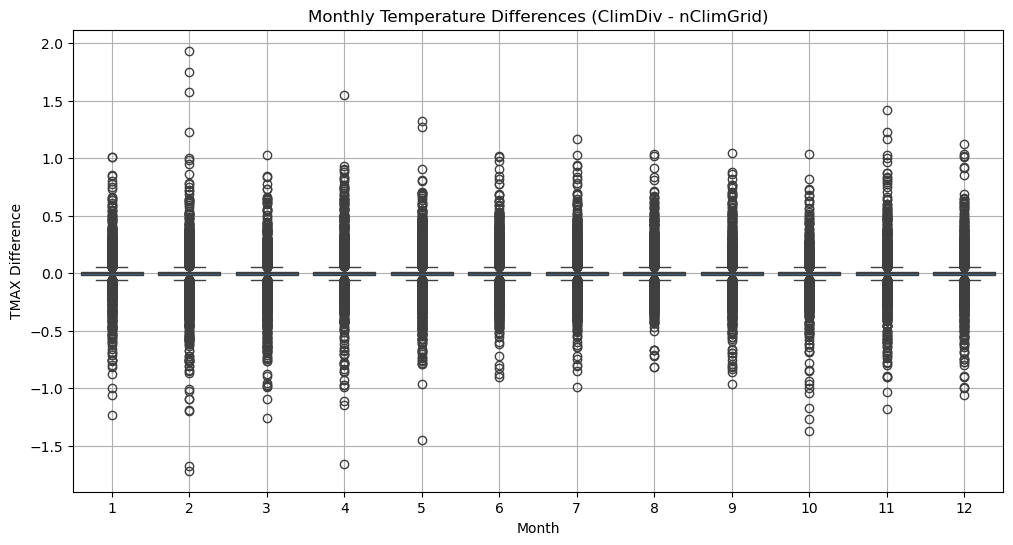


Precipitation Differences (by Month):
         count  unique    top   freq
month                               
1      27813.0  2823.0  0.000  216.0
2      27813.0  2780.0  0.000  157.0
3      27813.0  2885.0 -0.030  118.0
4      27813.0  2632.0 -0.012  111.0
5      27813.0  2764.0  0.076  113.0
6      27813.0  2672.0 -0.054  123.0
7      27813.0  2947.0 -0.060  128.0
8      27813.0  2602.0 -0.060  113.0
9      27813.0  2837.0 -0.030  111.0
10     27813.0  2802.0  0.000  208.0
11     27813.0  2896.0  0.000  175.0
12     27813.0  2942.0  0.000  133.0


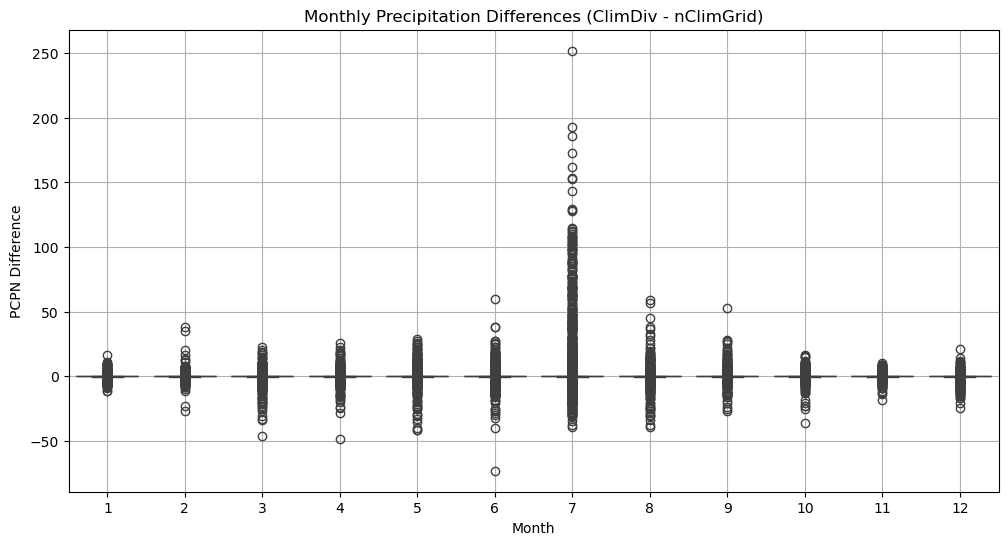


Calculating Yearly Totals/Averages for comparison...

Descriptive Statistics of YEARLY Differences (climdiv - nclimgrid):

Yearly Total Precipitation Difference:
count     27813.000
unique     5987.000
top           0.012
freq         49.000
Name: yearly_pcpn_total_diff, dtype: float64

Yearly Average TMAX Difference:
count     27813.000000
unique    27729.000000
top          -0.000672
freq          3.000000
Name: yearly_tmax_avg_diff, dtype: float64


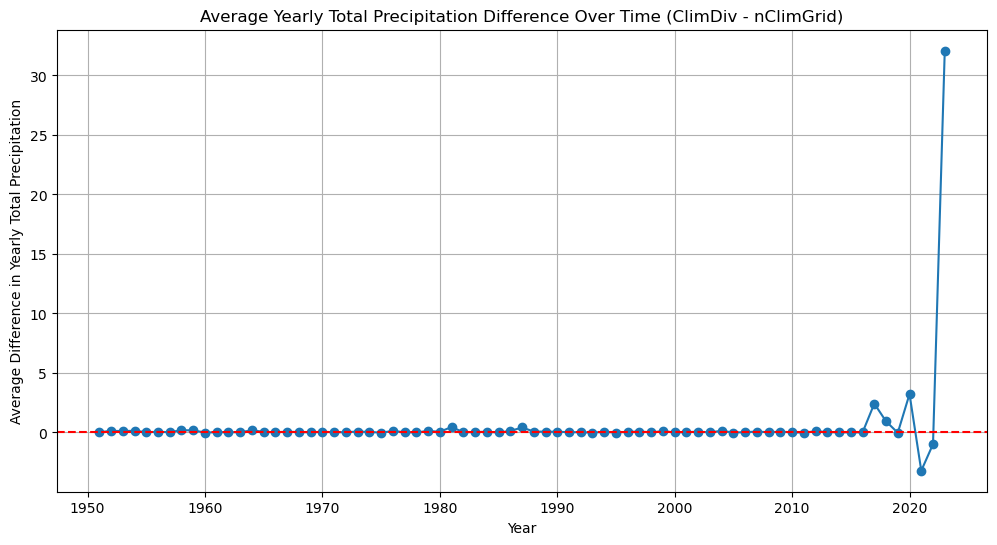

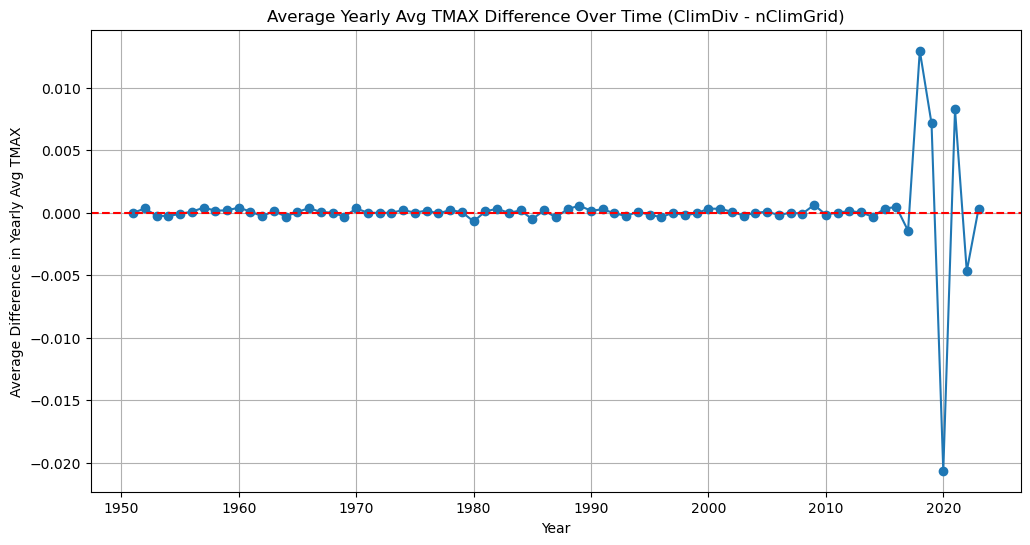


Sample of Monthly Comparison Data (monthly_comparison_df):
   year  state  county  month tmax_climdiv pcpn_climdiv  tmax_nclimgrid  \
0  1951     17       1      1     2.277778       35.306        2.280645   
1  1951     17       1      2     4.222222       90.932        4.206786   
2  1951     17       1      3     6.555556      145.796        6.574194   
3  1951     17       1      4         14.5       64.262       14.503333   
4  1951     17       1      5    24.666667       61.214       24.640968   

   pcpn_nclimgrid tmax_diff pcpn_diff  
0           35.40 -0.002867    -0.094  
1           90.99  0.015437    -0.058  
2          145.78 -0.018638     0.016  
3           64.29 -0.003333    -0.028  
4           61.17  0.025699     0.044  

Sample of Yearly Comparison Data (yearly_comp_df):
   year  state  county yearly_pcpn_total_climdiv  yearly_pcpn_total_nclimgrid  \
0  1951     17       1                   978.154                       978.04   
1  1951     17       3             

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats # Added for completeness, though not used in the fix itself but was in the previous good script.


# to avoid warnings, create copies:
df_tmax_filtered = df_tmax_filtered.copy()
df_pcpn_filtered = df_pcpn_filtered.copy()
df_processed_weather_pd = df_processed_weather_pd.copy()


print("--- Starting Monthly and Yearly Data Comparison ---")

# --- 1. Prepare ClimDiv Data ---
print("\nProcessing ClimDiv data...")
month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 
             'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
months_cols = list(month_map.keys())

# Temperature
df_tmax_filtered['county'] = df_tmax_filtered['county'].astype(int) 
df_tmax_filtered['year'] = df_tmax_filtered['year'].astype(int) # Ensure year is int from start
df_tmax_filtered['state'] = df_tmax_filtered['state'].astype(int) # Ensure state is int from start
tmax_climdiv_long = pd.melt(df_tmax_filtered, 
                            id_vars=['year', 'state', 'county'], 
                            value_vars=months_cols, 
                            var_name='month_name', 
                            value_name='tmax_climdiv')
tmax_climdiv_long['month'] = tmax_climdiv_long['month_name'].map(month_map)

# Precipitation
df_pcpn_filtered['county'] = df_pcpn_filtered['county'].astype(int) 
df_pcpn_filtered['year'] = df_pcpn_filtered['year'].astype(int) # Ensure year is int from start
df_pcpn_filtered['state'] = df_pcpn_filtered['state'].astype(int) # Ensure state is int from start
pcpn_climdiv_long = pd.melt(df_pcpn_filtered,
                            id_vars=['year', 'state', 'county'],
                            value_vars=months_cols,
                            var_name='month_name',
                            value_name='pcpn_climdiv')
pcpn_climdiv_long['month'] = pcpn_climdiv_long['month_name'].map(month_map)

climdiv_long_df = pd.merge(tmax_climdiv_long[['year', 'state', 'county', 'month', 'tmax_climdiv']],
                             pcpn_climdiv_long[['year', 'state', 'county', 'month', 'pcpn_climdiv']],
                             on=['year', 'state', 'county', 'month'],
                             how='outer')
print(f"ClimDiv data processed. Shape: {climdiv_long_df.shape}")
# print(climdiv_long_df.head()) # Optional: uncomment to verify

# --- 2. Prepare nClimGrid Data (from df_processed_weather_pd) ---
print("\nProcessing nClimGrid data...")
nclim_tmax_cols = [f'tmax_avg_{m.lower()}' for m in months_cols]
nclim_pcpn_cols = [f'prcp_tot_{m.lower()}' for m in months_cols]

actual_nclim_tmax_cols = [col for col in nclim_tmax_cols if col in df_processed_weather_pd.columns]
actual_nclim_pcpn_cols = [col for col in nclim_pcpn_cols if col in df_processed_weather_pd.columns]

id_vars_nclim = ['year', 'state', 'county'] 
# Ensure id_vars in df_processed_weather_pd are also integer type from the start
df_processed_weather_pd['year'] = df_processed_weather_pd['year'].astype(int)
df_processed_weather_pd['state'] = df_processed_weather_pd['state'].astype(int)
df_processed_weather_pd['county'] = df_processed_weather_pd['county'].astype(int)


if actual_nclim_tmax_cols:
    tmax_nclimgrid_long = pd.melt(df_processed_weather_pd,
                                  id_vars=id_vars_nclim,
                                  value_vars=actual_nclim_tmax_cols,
                                  var_name='month_var_tmax',
                                  value_name='tmax_nclimgrid')
    tmax_nclimgrid_long['month'] = tmax_nclimgrid_long['month_var_tmax'].str.split('_').str[-1].str.capitalize().map(month_map)
else:
    print("Warning: No nClimGrid TMAX columns found with the expected pattern.")
    tmax_nclimgrid_long = pd.DataFrame(columns=id_vars_nclim + ['month', 'tmax_nclimgrid'])

if actual_nclim_pcpn_cols:
    pcpn_nclimgrid_long = pd.melt(df_processed_weather_pd,
                                  id_vars=id_vars_nclim,
                                  value_vars=actual_nclim_pcpn_cols,
                                  var_name='month_var_pcpn',
                                  value_name='pcpn_nclimgrid')
    pcpn_nclimgrid_long['month'] = pcpn_nclimgrid_long['month_var_pcpn'].str.split('_').str[-1].str.capitalize().map(month_map)
else:
    print("Warning: No nClimGrid PCPN columns found with the expected pattern.")
    pcpn_nclimgrid_long = pd.DataFrame(columns=id_vars_nclim + ['month', 'pcpn_nclimgrid'])

if not tmax_nclimgrid_long.empty and not pcpn_nclimgrid_long.empty:
    nclimgrid_long_df = pd.merge(tmax_nclimgrid_long[id_vars_nclim + ['month', 'tmax_nclimgrid']],
                                 pcpn_nclimgrid_long[id_vars_nclim + ['month', 'pcpn_nclimgrid']],
                                 on=id_vars_nclim + ['month'],
                                 how='outer')
elif not tmax_nclimgrid_long.empty: # Only tmax data found
    nclimgrid_long_df = tmax_nclimgrid_long.copy()
    if 'pcpn_nclimgrid' not in nclimgrid_long_df.columns: nclimgrid_long_df['pcpn_nclimgrid'] = np.nan
elif not pcpn_nclimgrid_long.empty: # Only pcpn data found
    nclimgrid_long_df = pcpn_nclimgrid_long.copy()
    if 'tmax_nclimgrid' not in nclimgrid_long_df.columns: nclimgrid_long_df['tmax_nclimgrid'] = np.nan
else: # No data found
    nclimgrid_long_df = pd.DataFrame(columns=id_vars_nclim + ['month', 'tmax_nclimgrid', 'pcpn_nclimgrid'])


nclimgrid_long_df = nclimgrid_long_df[nclimgrid_long_df['year'] >= 1951].copy()
if 'tmax_nclimgrid' in nclimgrid_long_df and 'pcpn_nclimgrid' in nclimgrid_long_df :
    nclimgrid_long_df.dropna(subset=['tmax_nclimgrid', 'pcpn_nclimgrid'], how='all', inplace=True)

print(f"nClimGrid data processed. Shape: {nclimgrid_long_df.shape}")
# print(nclimgrid_long_df.head()) # Optional: uncomment to verify

# --- FIX: Ensure consistent data types for merge keys before the main merge ---
print("\nEnsuring consistent data types for merge keys...")
merge_keys = ['year', 'state', 'county', 'month']

for key in merge_keys:
    if key in climdiv_long_df.columns and key in nclimgrid_long_df.columns:
        print(f"  Converting '{key}': climdiv_dtype={climdiv_long_df[key].dtype}, nclimgrid_dtype={nclimgrid_long_df[key].dtype}")
        try:
            # Convert to numeric first to handle object types that are actually numbers
            climdiv_long_df[key] = pd.to_numeric(climdiv_long_df[key])
            nclimgrid_long_df[key] = pd.to_numeric(nclimgrid_long_df[key])
            
            # Then convert to integer
            climdiv_long_df[key] = climdiv_long_df[key].astype(int)
            nclimgrid_long_df[key] = nclimgrid_long_df[key].astype(int)
            print(f"    '{key}' converted to int. climdiv_dtype={climdiv_long_df[key].dtype}, nclimgrid_dtype={nclimgrid_long_df[key].dtype}")
        except ValueError as e:
            print(f"    Error converting key '{key}' to int: {e}. This might indicate non-numeric values or persistent NaNs.")
            # Handle specific cases or raise error if critical key fails
    elif key not in climdiv_long_df.columns:
        print(f"  Warning: Key '{key}' not found in climdiv_long_df.")
    elif key not in nclimgrid_long_df.columns:
        print(f"  Warning: Key '{key}' not found in nclimgrid_long_df.")


# --- 3. Combine Datasets for Monthly Comparison ---
print("\nMerging ClimDiv and nClimGrid monthly data...")
monthly_comparison_df = pd.merge(climdiv_long_df,
                                 nclimgrid_long_df,
                                 on=merge_keys, # use the list here
                                 how='inner') 

print(f"Monthly comparison data shape: {monthly_comparison_df.shape}")

if monthly_comparison_df.empty:
    print("No overlapping monthly data found between ClimDiv and nClimGrid. Halting further comparison.")
else:
    print(monthly_comparison_df.head())
    print("\n" + "="*50)
    print("IMPORTANT: UNIT CHECK NEEDED!")
    print("The differences calculated below are ONLY meaningful if units are identical OR after appropriate conversion.")
    # ... (rest of the script for calculations, plotting, and yearly analysis as before) ...
    print("="*50 + "\n")

    monthly_comparison_df['tmax_diff'] = monthly_comparison_df['tmax_climdiv'] - monthly_comparison_df['tmax_nclimgrid']
    monthly_comparison_df['pcpn_diff'] = monthly_comparison_df['pcpn_climdiv'] - monthly_comparison_df['pcpn_nclimgrid']

    # --- 4. Monthly Comparison Output ---
    print("\nDescriptive Statistics of MONTHLY Differences (climdiv - nclimgrid):")
    print("\nTemperature Differences (by Month):")
    print(monthly_comparison_df.groupby('month')['tmax_diff'].describe())
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=monthly_comparison_df, x='month', y='tmax_diff')
    plt.title('Monthly Temperature Differences (ClimDiv - nClimGrid)')
    plt.ylabel('TMAX Difference')
    plt.xlabel('Month')
    plt.grid(True)
    plt.show()

    print("\nPrecipitation Differences (by Month):")
    print(monthly_comparison_df.groupby('month')['pcpn_diff'].describe())

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=monthly_comparison_df, x='month', y='pcpn_diff')
    plt.title('Monthly Precipitation Differences (ClimDiv - nClimGrid)')
    plt.ylabel('PCPN Difference')
    plt.xlabel('Month')
    plt.grid(True)
    plt.show()

    # --- 5. Yearly Comparison ---
    print("\nCalculating Yearly Totals/Averages for comparison...")
    # Precipitation: Yearly Total
    yearly_pcpn_climdiv = monthly_comparison_df.groupby(['year', 'state', 'county'])['pcpn_climdiv'].sum().reset_index().rename(columns={'pcpn_climdiv': 'yearly_pcpn_total_climdiv'})
    yearly_pcpn_nclimgrid = monthly_comparison_df.groupby(['year', 'state', 'county'])['pcpn_nclimgrid'].sum().reset_index().rename(columns={'pcpn_nclimgrid': 'yearly_pcpn_total_nclimgrid'})
    
    # Temperature: Yearly Average of Monthly Maxes
    yearly_tmax_climdiv = monthly_comparison_df.groupby(['year', 'state', 'county'])['tmax_climdiv'].mean().reset_index().rename(columns={'tmax_climdiv': 'yearly_tmax_avg_climdiv'})
    yearly_tmax_nclimgrid = monthly_comparison_df.groupby(['year', 'state', 'county'])['tmax_nclimgrid'].mean().reset_index().rename(columns={'tmax_nclimgrid': 'yearly_tmax_avg_nclimgrid'})

    # Merge yearly data
    yearly_comp_df = pd.merge(yearly_pcpn_climdiv, yearly_pcpn_nclimgrid, on=['year', 'state', 'county'], how='inner')
    yearly_comp_df = pd.merge(yearly_comp_df, yearly_tmax_climdiv, on=['year', 'state', 'county'], how='inner')
    yearly_comp_df = pd.merge(yearly_comp_df, yearly_tmax_nclimgrid, on=['year', 'state', 'county'], how='inner')
    
    yearly_comp_df['yearly_pcpn_total_diff'] = yearly_comp_df['yearly_pcpn_total_climdiv'] - yearly_comp_df['yearly_pcpn_total_nclimgrid']
    yearly_comp_df['yearly_tmax_avg_diff'] = yearly_comp_df['yearly_tmax_avg_climdiv'] - yearly_comp_df['yearly_tmax_avg_nclimgrid']
    
    print("\nDescriptive Statistics of YEARLY Differences (climdiv - nclimgrid):")
    print("\nYearly Total Precipitation Difference:")
    print(yearly_comp_df['yearly_pcpn_total_diff'].describe())
    
    print("\nYearly Average TMAX Difference:")
    print(yearly_comp_df['yearly_tmax_avg_diff'].describe())

    # Plot time series of average yearly differences
    avg_yearly_pcpn_diff_ts = yearly_comp_df.groupby('year')['yearly_pcpn_total_diff'].mean()
    avg_yearly_tmax_diff_ts = yearly_comp_df.groupby('year')['yearly_tmax_avg_diff'].mean()

    plt.figure(figsize=(12, 6))
    avg_yearly_pcpn_diff_ts.plot(kind='line', marker='o')
    plt.title('Average Yearly Total Precipitation Difference Over Time (ClimDiv - nClimGrid)')
    plt.ylabel('Average Difference in Yearly Total Precipitation')
    plt.xlabel('Year')
    plt.axhline(0, color='red', linestyle='--')
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 6))
    avg_yearly_tmax_diff_ts.plot(kind='line', marker='o')
    plt.title('Average Yearly Avg TMAX Difference Over Time (ClimDiv - nClimGrid)')
    plt.ylabel('Average Difference in Yearly Avg TMAX')
    plt.xlabel('Year')
    plt.axhline(0, color='red', linestyle='--')
    plt.grid(True)
    plt.show()

    # --- 6. Output Sample of Comparison Table ---
    print("\nSample of Monthly Comparison Data (monthly_comparison_df):")
    print(monthly_comparison_df.head())
    
    print("\nSample of Yearly Comparison Data (yearly_comp_df):")
    print(yearly_comp_df.head())

print("\n--- Comparison Script Finished ---")

In [11]:
import pandas as pd
import numpy as np
from IPython.display import display # For explicitly displaying DataFrames
import scipy.stats as stats # Required if used by monthly_comparison_df creation

# Ensure all columns are shown for wide tables
pd.set_option('display.max_columns', None)

# --- Assume DataFrames are loaded from a previous cell ---
# df_tmax_filtered, df_pcpn_filtered, df_processed_weather_pd

# Make copies to work on
print("--- Preparing Data for County Identification and Display ---")
try:
    # Copies for the identification part (monthly_comparison_df creation)
    tmax_climdiv_for_comp = df_tmax_filtered.copy()
    pcpn_climdiv_for_comp = df_pcpn_filtered.copy()
    nclimgrid_for_comp = df_processed_weather_pd.copy()

    # Copies for the final rudimentary display part
    tmax_climdiv_df_display_base = df_tmax_filtered.copy()
    pcpn_climdiv_df_display_base = df_pcpn_filtered.copy()
    nclimgrid_df_display_base = df_processed_weather_pd.copy()

except NameError:
    print("Error: One or more input DataFrames (df_tmax_filtered, df_pcpn_filtered, df_processed_weather_pd) not found.")
    print("Please ensure they are loaded in a previous cell. Cannot proceed.")
    raise


# SECTION 1: County Identification ============================================
print("\n--- Section 1: Identifying Specific Counties with Large Differences (2018-2023) ---")

# --- 1.1 Prepare ClimDiv Data for Comparison DF ---
month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 
             'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
months_cols_climdiv_standard = list(month_map.keys())

# Ensure essential columns exist before processing
if not all(col in tmax_climdiv_for_comp.columns for col in ['county', 'year', 'state'] + months_cols_climdiv_standard):
    print("Error: df_tmax_filtered (tmax_climdiv_for_comp) is missing required columns for melting.")
    # Create an empty df to allow script to proceed further down where it checks for empty DFs
    climdiv_long_df_comp = pd.DataFrame() 
else:
    tmax_climdiv_for_comp['county'] = tmax_climdiv_for_comp['county'].astype(str).str.lstrip('0').astype(int)
    tmax_climdiv_for_comp['year'] = tmax_climdiv_for_comp['year'].astype(int)
    tmax_climdiv_for_comp['state'] = tmax_climdiv_for_comp['state'].astype(int)
    tmax_climdiv_long_comp = pd.melt(tmax_climdiv_for_comp, 
                                     id_vars=['year', 'state', 'county'], 
                                     value_vars=months_cols_climdiv_standard, 
                                     var_name='month_name', 
                                     value_name='tmax_climdiv')
    tmax_climdiv_long_comp['month'] = tmax_climdiv_long_comp['month_name'].map(month_map)

    if not all(col in pcpn_climdiv_for_comp.columns for col in ['county', 'year', 'state'] + months_cols_climdiv_standard):
        print("Error: df_pcpn_filtered (pcpn_climdiv_for_comp) is missing required columns for melting.")
        climdiv_long_df_comp = pd.DataFrame() # Ensure this is also handled
    else:
        pcpn_climdiv_for_comp['county'] = pcpn_climdiv_for_comp['county'].astype(str).str.lstrip('0').astype(int)
        pcpn_climdiv_for_comp['year'] = pcpn_climdiv_for_comp['year'].astype(int)
        pcpn_climdiv_for_comp['state'] = pcpn_climdiv_for_comp['state'].astype(int)
        pcpn_climdiv_long_comp = pd.melt(pcpn_climdiv_for_comp,
                                         id_vars=['year', 'state', 'county'],
                                         value_vars=months_cols_climdiv_standard,
                                         var_name='month_name',
                                         value_name='pcpn_climdiv')
        pcpn_climdiv_long_comp['month'] = pcpn_climdiv_long_comp['month_name'].map(month_map)

        climdiv_long_df_comp = pd.merge(tmax_climdiv_long_comp[['year', 'state', 'county', 'month', 'tmax_climdiv']],
                                        pcpn_climdiv_long_comp[['year', 'state', 'county', 'month', 'pcpn_climdiv']],
                                        on=['year', 'state', 'county', 'month'],
                                        how='outer')

# --- 1.2 Prepare nClimGrid Data for Comparison DF ---
nclim_tmax_cols_comp = [f'tmax_avg_{m.lower()}' for m in months_cols_climdiv_standard]
nclim_pcpn_cols_comp = [f'prcp_tot_{m.lower()}' for m in months_cols_climdiv_standard]
id_vars_nclim_comp = ['year', 'state', 'county']

if not all(col in nclimgrid_for_comp.columns for col in id_vars_nclim_comp):
    print("Error: df_processed_weather_pd (nclimgrid_for_comp) is missing required id_vars for melting.")
    nclimgrid_long_df_comp = pd.DataFrame()
else:
    nclimgrid_for_comp['year'] = nclimgrid_for_comp['year'].astype(int)
    nclimgrid_for_comp['state'] = nclimgrid_for_comp['state'].astype(int)
    nclimgrid_for_comp['county'] = nclimgrid_for_comp['county'].astype(int)

    actual_nclim_tmax_cols_comp = [col for col in nclim_tmax_cols_comp if col in nclimgrid_for_comp.columns]
    actual_nclim_pcpn_cols_comp = [col for col in nclim_pcpn_cols_comp if col in nclimgrid_for_comp.columns]

    if actual_nclim_tmax_cols_comp:
        tmax_nclimgrid_long_comp = pd.melt(nclimgrid_for_comp, id_vars=id_vars_nclim_comp, value_vars=actual_nclim_tmax_cols_comp, var_name='month_var_tmax', value_name='tmax_nclimgrid')
        tmax_nclimgrid_long_comp['month'] = tmax_nclimgrid_long_comp['month_var_tmax'].str.split('_').str[-1].str.capitalize().map(month_map)
    else: tmax_nclimgrid_long_comp = pd.DataFrame(columns=id_vars_nclim_comp + ['month', 'tmax_nclimgrid'])

    if actual_nclim_pcpn_cols_comp:
        pcpn_nclimgrid_long_comp = pd.melt(nclimgrid_for_comp, id_vars=id_vars_nclim_comp, value_vars=actual_nclim_pcpn_cols_comp, var_name='month_var_pcpn', value_name='pcpn_nclimgrid')
        pcpn_nclimgrid_long_comp['month'] = pcpn_nclimgrid_long_comp['month_var_pcpn'].str.split('_').str[-1].str.capitalize().map(month_map)
    else: pcpn_nclimgrid_long_comp = pd.DataFrame(columns=id_vars_nclim_comp + ['month', 'pcpn_nclimgrid'])

    if not tmax_nclimgrid_long_comp.empty and not pcpn_nclimgrid_long_comp.empty :
        nclimgrid_long_df_comp = pd.merge(tmax_nclimgrid_long_comp[id_vars_nclim_comp + ['month', 'tmax_nclimgrid']], pcpn_nclimgrid_long_comp[id_vars_nclim_comp + ['month', 'pcpn_nclimgrid']], on=id_vars_nclim_comp + ['month'], how='outer')
    elif not tmax_nclimgrid_long_comp.empty: nclimgrid_long_df_comp = tmax_nclimgrid_long_comp.copy(); nclimgrid_long_df_comp['pcpn_nclimgrid'] = np.nan
    elif not pcpn_nclimgrid_long_comp.empty: nclimgrid_long_df_comp = pcpn_nclimgrid_long_comp.copy(); nclimgrid_long_df_comp['tmax_nclimgrid'] = np.nan
    else: nclimgrid_long_df_comp = pd.DataFrame(columns=id_vars_nclim_comp + ['month', 'tmax_nclimgrid', 'pcpn_nclimgrid'])

    if 'year' in nclimgrid_long_df_comp.columns and not nclimgrid_long_df_comp.empty: 
        nclimgrid_long_df_comp = nclimgrid_long_df_comp[nclimgrid_long_df_comp['year'] >= 1951].copy()
        if 'tmax_nclimgrid' in nclimgrid_long_df_comp and 'pcpn_nclimgrid' in nclimgrid_long_df_comp :
            nclimgrid_long_df_comp.dropna(subset=['tmax_nclimgrid', 'pcpn_nclimgrid'], how='all', inplace=True)

# --- 1.3 Create monthly_comparison_df ---
merge_keys_comp = ['year', 'state', 'county', 'month'] 
if not climdiv_long_df_comp.empty and not nclimgrid_long_df_comp.empty:
    for key in merge_keys_comp: 
        if key in climdiv_long_df_comp.columns: climdiv_long_df_comp[key] = climdiv_long_df_comp[key].astype(int)
        if key in nclimgrid_long_df_comp.columns: nclimgrid_long_df_comp[key] = nclimgrid_long_df_comp[key].astype(int)
    monthly_comparison_df = pd.merge(climdiv_long_df_comp, nclimgrid_long_df_comp, on=merge_keys_comp, how='inner')
else:
    print("Warning: One or both DFs for creating monthly_comparison_df are empty. Cannot create comparison.")
    monthly_comparison_df = pd.DataFrame()

if not monthly_comparison_df.empty:
    if 'tmax_climdiv' in monthly_comparison_df and 'tmax_nclimgrid' in monthly_comparison_df:
         monthly_comparison_df['tmax_diff'] = monthly_comparison_df['tmax_climdiv'] - monthly_comparison_df['tmax_nclimgrid']
    if 'pcpn_climdiv' in monthly_comparison_df and 'pcpn_nclimgrid' in monthly_comparison_df:
        monthly_comparison_df['pcpn_diff'] = monthly_comparison_df['pcpn_climdiv'] - monthly_comparison_df['pcpn_nclimgrid']
    print(f"Monthly comparison DataFrame created for identification. Shape: {monthly_comparison_df.shape}")
else:
    print("Error: monthly_comparison_df is empty after merge. Cannot identify differing counties.")


# --- 1.4 Identify Counties with Large Differences ---
list_of_counties_for_display = [] 

if not monthly_comparison_df.empty:
    start_year_for_recent = 2018
    recent_comp_df = monthly_comparison_df[monthly_comparison_df['year'] >= start_year_for_recent].copy()

    if not recent_comp_df.empty:
        # Ensure diff columns exist before taking abs()
        if 'tmax_diff' in recent_comp_df.columns:
            recent_comp_df['abs_tmax_diff'] = recent_comp_df['tmax_diff'].abs()
        else:
            print("Warning: 'tmax_diff' column missing in recent_comp_df. Cannot calculate abs_tmax_diff.")
            recent_comp_df['abs_tmax_diff'] = np.nan # Create column to prevent error in agg

        if 'pcpn_diff' in recent_comp_df.columns:
            recent_comp_df['abs_pcpn_diff'] = recent_comp_df['pcpn_diff'].abs()
        else:
            print("Warning: 'pcpn_diff' column missing in recent_comp_df. Cannot calculate abs_pcpn_diff.")
            recent_comp_df['abs_pcpn_diff'] = np.nan # Create column to prevent error in agg
        
        # Ensure 'month' column exists for count_months aggregation
        if 'month' in recent_comp_df.columns and 'state' in recent_comp_df.columns and 'county' in recent_comp_df.columns:
            county_mean_abs_diffs = recent_comp_df.groupby(['state', 'county']).agg(
                mean_abs_tmax_diff=('abs_tmax_diff', 'mean'),
                mean_abs_pcpn_diff=('abs_pcpn_diff', 'mean'),
                count_months=('month', 'count') 
            ).reset_index()
            county_mean_abs_diffs = county_mean_abs_diffs[county_mean_abs_diffs['count_months'] > 0]

            if not county_mean_abs_diffs.empty:
                # These are only defined if county_mean_abs_diffs is not empty
                top_5_tmax_s_c = list(county_mean_abs_diffs.sort_values(by='mean_abs_tmax_diff', ascending=False).head(5)[['state', 'county']].itertuples(index=False, name=None))
                top_5_pcpn_s_c = list(county_mean_abs_diffs.sort_values(by='mean_abs_pcpn_diff', ascending=False).head(5)[['state', 'county']].itertuples(index=False, name=None))
                
                # This line now correctly sits inside the block where its inputs are defined
                list_of_counties_for_display = list(set(top_5_tmax_s_c) | set(top_5_pcpn_s_c)) 
                
                print(f"\nIdentified {len(list_of_counties_for_display)} specific (state, county) pairs based on recent differences:")
                print("Top 5 for TMAX diff (state, county):", top_5_tmax_s_c)
                print("Top 5 for PCPN diff (state, county):", top_5_pcpn_s_c)
            else:
                print("No county average differences could be calculated (county_mean_abs_diffs is empty).")
        else:
            print("Warning: 'month', 'state', or 'county' column not found in recent_comp_df for count_months aggregation.")
    else:
        print(f"No data found from year {start_year_for_recent} onwards in 'monthly_comparison_df' for county identification.")
else:
    print("Skipping county identification as 'monthly_comparison_df' is empty or not created.")

if not list_of_counties_for_display:
    print("\nWARNING: No specific counties were identified by Section 1. The display below will likely be empty.")


# ########################################################################################
# ###                                                                                  ###
# ###      NOW STARTING THE MODIFIED VERSION OF YOUR ORIGINAL RUDIMENTARY DISPLAY SCRIPT ###
# ###   DISPLAYING DATA FOR THE SPECIFIC COUNTIES IDENTIFIED IN SECTION 1 ABOVE        ###
# ###                                                                                  ###
# ########################################################################################


# SECTION 2: Rudimentary Display Script (User's script, minimally modified) =========
print("\n\n--- Section 2: Rudimentary Display for Specific Identified Counties ---")

tmax_climdiv_df = tmax_climdiv_df_display_base 
pcpn_climdiv_df = pcpn_climdiv_df_display_base
nclimgrid_df = nclimgrid_df_display_base

# --- 2.1. Define Target Years and use IDENTIFIED Counties ---
years_to_display = list(range(2013, 2024)) 

specific_s_c_tuples = list_of_counties_for_display 
print(f"\nDisplaying data for {len(specific_s_c_tuples)} specific counties: {specific_s_c_tuples}")

# --- 2.2. Prepare DataFrames' key types (as in your script) ---
if not tmax_climdiv_df.empty:
    if 'county' in tmax_climdiv_df.columns: tmax_climdiv_df['county'] = tmax_climdiv_df['county'].astype(str).str.lstrip('0').astype(int)
    if 'state' in tmax_climdiv_df.columns: tmax_climdiv_df['state'] = tmax_climdiv_df['state'].astype(int)
    if 'year' in tmax_climdiv_df.columns: tmax_climdiv_df['year'] = tmax_climdiv_df['year'].astype(int)
if not pcpn_climdiv_df.empty:
    if 'county' in pcpn_climdiv_df.columns: pcpn_climdiv_df['county'] = pcpn_climdiv_df['county'].astype(str).str.lstrip('0').astype(int)
    if 'state' in pcpn_climdiv_df.columns: pcpn_climdiv_df['state'] = pcpn_climdiv_df['state'].astype(int)
    if 'year' in pcpn_climdiv_df.columns: pcpn_climdiv_df['year'] = pcpn_climdiv_df['year'].astype(int)
if not nclimgrid_df.empty:
    if 'year' in nclimgrid_df.columns: nclimgrid_df['year'] = nclimgrid_df['year'].astype(int)
    if 'state' in nclimgrid_df.columns: nclimgrid_df['state'] = nclimgrid_df['state'].astype(int)
    if 'county' in nclimgrid_df.columns: nclimgrid_df['county'] = nclimgrid_df['county'].astype(int)

# --- 2.3. Define Month Column Lists (as in your script) ---
climdiv_month_columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
nclimgrid_month_abbr_lower = [m.lower() for m in climdiv_month_columns]
nclimgrid_tmax_month_columns = [f'tmax_avg_{m}' for m in nclimgrid_month_abbr_lower]
nclimgrid_pcpn_month_columns = [f'prcp_tot_{m}' for m in nclimgrid_month_abbr_lower]

# --- 2.4. Filter and Display Data (Rudimentary - your script's logic) ---
def build_mask(df, state_county_pairs):
    if df.empty or not state_county_pairs or not ('state' in df.columns and 'county' in df.columns) : 
        return pd.Series(False, index=df.index) if not df.empty else pd.Series(dtype=bool)
    combined_mask = pd.Series(False, index=df.index)
    # Ensure state/county in df are int for comparison if they somehow weren't already
    df_state_col = df['state'].astype(int)
    df_county_col = df['county'].astype(int)
    for state_val, county_val in state_county_pairs:
        mask_condition = (df_state_col == int(state_val)) & (df_county_col == int(county_val))
        combined_mask = combined_mask | mask_condition
    return combined_mask

# ClimDiv TMAX
if not tmax_climdiv_df.empty and specific_s_c_tuples and 'year' in tmax_climdiv_df.columns: 
    tmax_climdiv_filtered_y = tmax_climdiv_df[tmax_climdiv_df['year'].isin(years_to_display)]
    if not tmax_climdiv_filtered_y.empty : 
        tmax_climdiv_mask_c = build_mask(tmax_climdiv_filtered_y, specific_s_c_tuples)
        cols_to_select_tmax_climdiv = ['state', 'county', 'year'] + [col for col in climdiv_month_columns if col in tmax_climdiv_filtered_y.columns]
        # Ensure all selected columns actually exist
        cols_to_select_tmax_climdiv = [col for col in cols_to_select_tmax_climdiv if col in tmax_climdiv_filtered_y.columns]

        tmax_climdiv_display_df = tmax_climdiv_filtered_y[tmax_climdiv_mask_c]
        if not tmax_climdiv_display_df.empty and set(cols_to_select_tmax_climdiv).issubset(tmax_climdiv_display_df.columns):
             tmax_climdiv_display_df = tmax_climdiv_display_df[cols_to_select_tmax_climdiv].sort_values(by=['state', 'county', 'year'])
        
        print("--- ClimDiv: Monthly Max Temperatures (Years 2013-2023, Specific Identified Counties) ---")
        if not tmax_climdiv_display_df.empty: display(tmax_climdiv_display_df)
        else: print("No ClimDiv TMAX data to display after filtering for specific counties.")
    else:
        print("--- ClimDiv: Monthly Max Temperatures - No data for selected years or no specific counties. ---")
else:
    print("--- ClimDiv: TMAX source DataFrame (tmax_climdiv_df) is empty, missing year col, or no specific counties identified. ---")

# ClimDiv PCPN
if not pcpn_climdiv_df.empty and specific_s_c_tuples and 'year' in pcpn_climdiv_df.columns:
    pcpn_climdiv_filtered_y = pcpn_climdiv_df[pcpn_climdiv_df['year'].isin(years_to_display)]
    if not pcpn_climdiv_filtered_y.empty :
        pcpn_climdiv_mask_c = build_mask(pcpn_climdiv_filtered_y, specific_s_c_tuples)
        cols_to_select_pcpn_climdiv = ['state', 'county', 'year'] + [col for col in climdiv_month_columns if col in pcpn_climdiv_filtered_y.columns]
        cols_to_select_pcpn_climdiv = [col for col in cols_to_select_pcpn_climdiv if col in pcpn_climdiv_filtered_y.columns]

        pcpn_climdiv_display_df = pcpn_climdiv_filtered_y[pcpn_climdiv_mask_c]
        if not pcpn_climdiv_display_df.empty and set(cols_to_select_pcpn_climdiv).issubset(pcpn_climdiv_display_df.columns):
            pcpn_climdiv_display_df = pcpn_climdiv_display_df[cols_to_select_pcpn_climdiv].sort_values(by=['state', 'county', 'year'])

        print("\n--- ClimDiv: Monthly Precipitation (Years 2013-2023, Specific Identified Counties) ---")
        if not pcpn_climdiv_display_df.empty: display(pcpn_climdiv_display_df)
        else: print("No ClimDiv PCPN data to display after filtering for specific counties.")
    else:
        print("\n--- ClimDiv: Monthly Precipitation - No data for selected years or no specific counties. ---")
else:
    print("\n--- ClimDiv: PCPN source DataFrame (pcpn_climdiv_df) is empty, missing year col, or no specific counties identified. ---")

# nClimGrid
if not nclimgrid_df.empty and specific_s_c_tuples and 'year' in nclimgrid_df.columns:
    if 'state' in nclimgrid_df.columns and 'county' in nclimgrid_df.columns:
        nclimgrid_mask_for_specific_counties = build_mask(nclimgrid_df, specific_s_c_tuples)
        nclimgrid_filtered_yc = nclimgrid_df[
            nclimgrid_df['year'].isin(years_to_display) & nclimgrid_mask_for_specific_counties
        ]
    else:
        print("\n--- nClimGrid - Missing 'state' or 'county' columns, cannot filter for specific counties. ---")
        nclimgrid_filtered_yc = pd.DataFrame()

    if not nclimgrid_filtered_yc.empty:
        base_cols_nclim = ['state', 'county', 'year']
        
        existing_nclimgrid_tmax_cols = [col for col in nclimgrid_tmax_month_columns if col in nclimgrid_filtered_yc.columns]
        actual_display_cols_nclim_tmax = [col for col in (base_cols_nclim + existing_nclimgrid_tmax_cols) if col in nclimgrid_filtered_yc.columns]
        if len(actual_display_cols_nclim_tmax) > len(base_cols_nclim): 
            nclimgrid_tmax_display_df = nclimgrid_filtered_yc[actual_display_cols_nclim_tmax].sort_values(by=['state', 'county', 'year'])
            print("\n--- nClimGrid: Monthly Max Temperatures (Years 2013-2023, Specific Identified Counties) ---")
            if not nclimgrid_tmax_display_df.empty: display(nclimgrid_tmax_display_df)
            else: print("No nClimGrid TMAX data after filtering for specific counties.")
        else:
            print("\n--- nClimGrid: TMAX - Not enough monthly columns found or data empty after filtering. ---")

        existing_nclimgrid_pcpn_cols = [col for col in nclimgrid_pcpn_month_columns if col in nclimgrid_filtered_yc.columns]
        actual_display_cols_nclim_pcpn = [col for col in (base_cols_nclim + existing_nclimgrid_pcpn_cols) if col in nclimgrid_filtered_yc.columns]
        if len(actual_display_cols_nclim_pcpn) > len(base_cols_nclim): 
            nclimgrid_pcpn_display_df = nclimgrid_filtered_yc[actual_display_cols_nclim_pcpn].sort_values(by=['state', 'county', 'year'])
            print("\n--- nClimGrid: Monthly Precipitation (Years 2013-2023, Specific Identified Counties) ---")
            if not nclimgrid_pcpn_display_df.empty: display(nclimgrid_pcpn_display_df)
            else: print("No nClimGrid PCPN data after filtering for specific counties.")
        else:
            print("\n--- nClimGrid: PCPN - Not enough monthly columns found or data empty after filtering. ---")
    else:
        print("\n--- nClimGrid - No data after filtering for specific counties and years. ---")
elif not specific_s_c_tuples:
     print("\n--- nClimGrid - Skipping display as no specific counties were identified. ---")
else:
    print("\n--- nClimGrid - Source DataFrame (nclimgrid_df) is empty or missing year col. ---")

print("\n--- Rudimentary Display for Specific Counties Complete ---")
print("Units are confirmed to be the same by you. Great!")

--- Preparing Data for County Identification and Display ---

--- Section 1: Identifying Specific Counties with Large Differences (2018-2023) ---
Monthly comparison DataFrame created for identification. Shape: (333756, 10)

Identified 10 specific (state, county) pairs based on recent differences:
Top 5 for TMAX diff (state, county): [(27, 135), (27, 87), (27, 89), (31, 143), (31, 185)]
Top 5 for PCPN diff (state, county): [(17, 153), (17, 3), (17, 51), (17, 181), (27, 143)]


--- Section 2: Rudimentary Display for Specific Identified Counties ---

Displaying data for 10 specific counties: [(31, 185), (17, 181), (31, 143), (27, 143), (17, 3), (27, 87), (17, 51), (27, 135), (17, 153), (27, 89)]
--- ClimDiv: Monthly Max Temperatures (Years 2013-2023, Specific Identified Counties) ---


,state,county,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
73048,17,3,2013,7.444444,8.333333,9.944444,19.333333,25.166667,29.944444,29.555556,29.666667,28.444444,20.888889,12.222222,6.611111
73049,17,3,2014,3.777778,4.944444,11.833333,21.0,25.888889,29.5,29.388889,31.222222,27.0,21.777778,9.888889,7.611111
73050,17,3,2015,5.833333,3.222222,12.388889,21.777778,25.5,29.944444,31.277778,30.055556,28.555556,22.055556,16.166667,13.444444
73051,17,3,2016,5.722222,9.888889,17.388889,21.944444,24.444444,31.722222,31.777778,30.833333,29.444444,24.555556,17.166667,7.722222
73052,17,3,2017,9.055556,14.388889,15.222222,22.611111,25.388889,30.0,32.0,29.333333,28.888889,22.611111,14.777778,7.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222554,31,185,2019,1.111111,-2.611111,5.777778,18.555556,20.222222,27.777778,30.611111,27.722222,27.777778,15.166667,9.0,5.111111
222555,31,185,2020,0.944444,5.5,11.666667,17.277778,20.333333,30.888889,30.111111,29.555556,24.5,16.166667,14.277778,5.611111
222556,31,185,2021,3.111111,-5.111111,13.611111,17.055556,21.666667,30.611111,29.888889,30.555556,27.944444,19.944444,13.0,8.888889
222557,31,185,2022,3.555556,5.555556,11.888889,17.666667,22.5,30.333333,30.888889,31.555556,28.166667,20.111111,9.555556,0.666667



--- ClimDiv: Monthly Precipitation (Years 2013-2023, Specific Identified Counties) ---


,state,county,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
73048,17,3,2013,122.174,79.248,73.914,113.03,96.012,168.91,66.802,77.724,50.8,129.54,71.12,151.384
73049,17,3,2014,43.688,46.228,47.498,190.754,105.41,145.542,68.326,77.216,44.45,112.522,60.96,68.072
73050,17,3,2015,84.328,77.216,190.246,116.078,147.066,94.234,235.458,64.77,36.83,35.052,208.534,151.638
73051,17,3,2016,60.706,70.358,166.878,110.744,173.736,35.052,199.644,171.958,90.424,19.05,90.424,103.124
73052,17,3,2017,50.546,35.306,97.282,213.614,156.464,90.932,55.88,55.118,29.464,94.234,87.63,70.358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222554,31,185,2019,5.08,28.194,75.438,33.02,200.152,136.398,117.602,173.99,51.308,64.262,32.766,45.466
222555,31,185,2020,30.988,1.778,58.166,24.892,128.27,72.898,133.604,30.734,42.926,14.224,44.196,22.606
222556,31,185,2021,35.306,17.526,185.674,40.386,116.078,75.692,49.276,113.03,39.37,73.914,12.446,6.858
222557,31,185,2022,4.064,0.762,30.48,54.102,135.636,95.758,90.678,27.178,47.244,9.398,8.128,8.128



--- nClimGrid: Monthly Max Temperatures (Years 2013-2023, Specific Identified Counties) ---


,state,county,year,tmax_avg_jan,tmax_avg_feb,tmax_avg_mar,tmax_avg_apr,tmax_avg_may,tmax_avg_jun,tmax_avg_jul,tmax_avg_aug,tmax_avg_sep,tmax_avg_oct,tmax_avg_nov,tmax_avg_dec
185,17,3,2013,7.433548,8.331429,9.948065,19.347333,25.160323,29.957000,29.573871,29.636129,28.443667,20.860000,12.233000,6.605806
186,17,3,2014,3.782581,4.961429,11.841290,20.971333,25.908387,29.475667,29.369677,31.212903,27.005333,21.761935,9.860333,7.601290
187,17,3,2015,5.818065,3.245357,12.411613,21.765333,25.497742,29.949000,31.299355,30.080000,28.526000,22.082581,16.185667,13.435484
188,17,3,2016,5.732258,9.869310,17.368710,21.952667,24.420968,31.724667,31.768710,30.846129,29.457667,24.536129,17.146000,7.740968
189,17,3,2017,9.048065,14.367857,15.224839,22.588667,25.390968,30.031333,32.030000,29.333871,28.869000,22.604839,14.776667,7.824194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37333,31,185,2019,1.137097,-2.619286,5.755484,18.581000,20.202903,27.786000,30.597742,27.712903,27.782333,15.160645,9.014000,5.096129
37334,31,185,2020,0.961613,5.515517,11.703871,17.269333,20.356452,30.909333,30.138065,29.550323,24.519333,16.161935,14.022667,5.611935
37335,31,185,2021,2.380323,-5.129286,13.620968,17.481000,22.096774,31.054000,29.872581,30.628710,27.976000,19.976774,13.016333,8.895806
37336,31,185,2022,3.890645,5.859286,12.217097,17.843667,22.972581,30.462333,31.695161,31.542581,28.724667,21.376774,10.231333,1.285806



--- nClimGrid: Monthly Precipitation (Years 2013-2023, Specific Identified Counties) ---


,state,county,year,prcp_tot_jan,prcp_tot_feb,prcp_tot_mar,prcp_tot_apr,prcp_tot_may,prcp_tot_jun,prcp_tot_jul,prcp_tot_aug,prcp_tot_sep,prcp_tot_oct,prcp_tot_nov,prcp_tot_dec
185,17,3,2013,122.19,79.20,73.98,112.94,96.00,168.92,66.87,77.84,50.71,129.47,71.03,151.46
186,17,3,2014,43.68,46.34,47.53,190.79,105.41,145.57,68.44,77.22,44.44,112.46,61.02,68.02
187,17,3,2015,84.43,77.18,190.36,116.15,147.17,94.29,235.38,64.89,36.78,35.08,208.42,151.57
188,17,3,2016,60.67,70.40,166.98,110.78,173.65,34.96,199.61,171.92,90.43,19.12,90.36,103.12
189,17,3,2017,50.42,35.33,97.31,213.59,156.67,90.91,55.99,55.27,29.22,94.35,87.81,70.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37333,31,185,2019,5.16,28.30,75.39,32.93,200.04,136.51,117.62,173.92,51.31,64.14,32.65,45.50
37334,31,185,2020,31.00,1.89,54.51,25.00,128.04,72.96,133.52,32.18,42.91,14.34,44.16,23.45
37335,31,185,2021,35.20,17.54,185.69,40.38,113.63,75.77,49.25,112.98,39.36,73.95,12.40,6.85
37336,31,185,2022,4.01,0.65,29.84,53.98,135.52,95.64,90.79,27.10,47.14,9.51,8.04,8.19



--- Rudimentary Display for Specific Counties Complete ---
Units are confirmed to be the same by you. Great!
